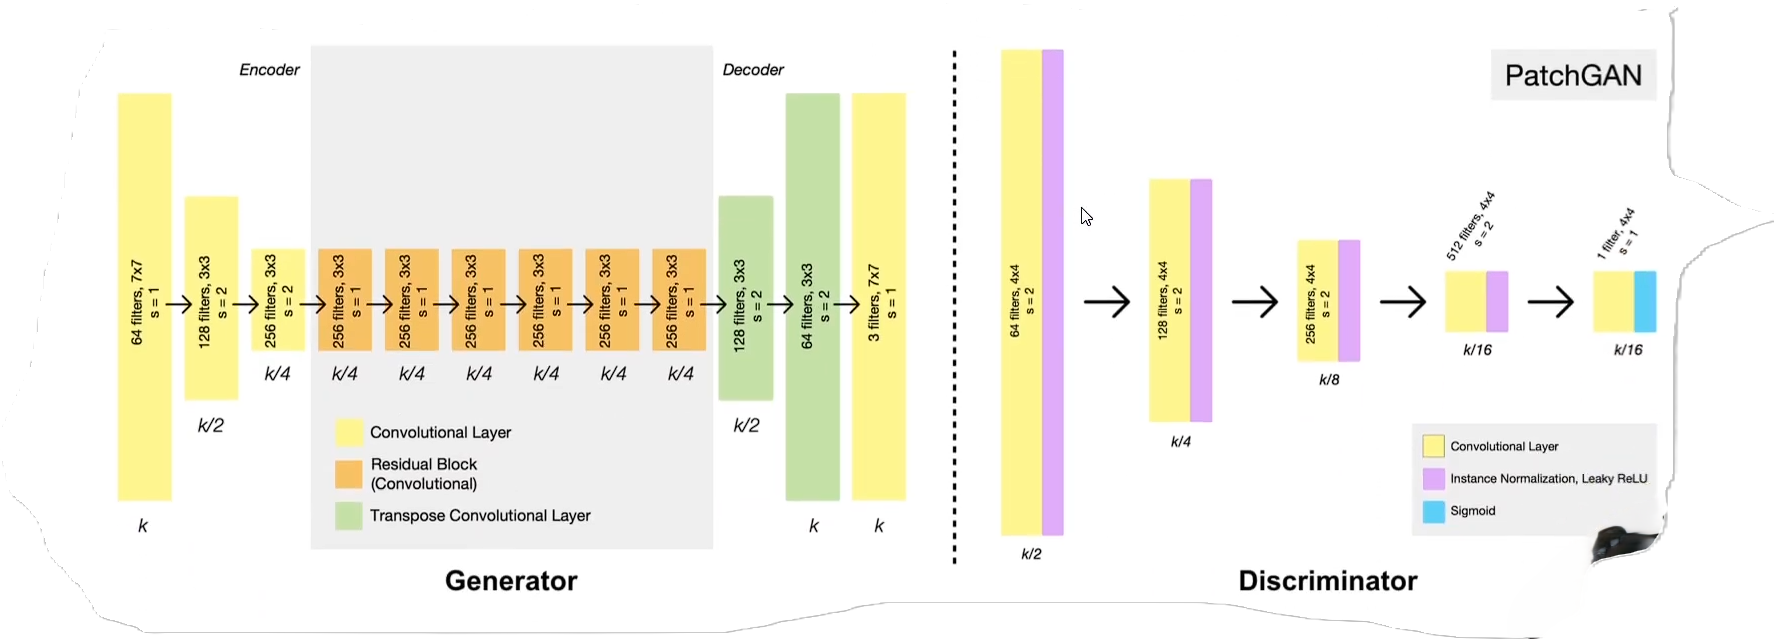

# DISCRIMINATOR

In [1]:
import torch
import torch.nn as nn
 
class DBlock(nn.Module):
    def __init__(self,in_channels,out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=4,
                stride=stride,
                padding=1,
                bias=True,
                padding_mode='reflect'
            ),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
    def forward(self,x): return self.conv(x)
class Discriminator(nn.Module):
    def __init__(self,in_channels, features = [64,128,256,512]):
        super().__init__()
        layers = list()
        init_channels = in_channels
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                DBlock(
                    in_channels=in_channels,
                    out_channels=feature, 
                    stride = 1 if feature==features[-1] else 2
                )
            )
            in_channels = feature
        self.discriminator = nn.Sequential(
            #initial
            nn.Sequential(
                nn.Conv2d(
                    in_channels=init_channels,
                    out_channels=features[0],
                    kernel_size=4,
                    stride=2,
                    padding=1,
                    padding_mode='reflect'
                ),
                nn.LeakyReLU(0.2)
            ),
            #intermediate
            nn.Sequential(*layers),
            #final
            nn.Conv2d(
                in_channels=in_channels,
                out_channels = 1,
                kernel_size=4,
                stride = 1,
                padding=1,
                padding_mode='reflect'
            ),
            nn.Sigmoid()
        )
    def forward(self,x):
        return self.discriminator(x)

def test():
    x = torch.randn((1,3,256,256))
    model = Discriminator(in_channels = 3)
    print(model(x).shape)
test()


torch.Size([1, 1, 30, 30])


# GENERATOR

In [2]:
import torch
import torch.nn as nn

class GBlock(nn.Module):
    def __init__(self,in_channels, out_channels, down = True, use_act = True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels = out_channels, padding_mode='reflect', **kwargs) 
            if down 
            else nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity()
        )
    def forward(self,x): return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self,channels):
        super().__init__()
        self.block = nn.Sequential(
            GBlock(in_channels=channels,out_channels=channels,use_act=True,kernel_size = 3,padding=1),
            GBlock(in_channels=channels,out_channels=channels,use_act=False,kernel_size = 3, padding=1),
        )
    def forward(self,x): return x+self.block(x)

class Generator(nn.Module):
    def __init__(self,in_channels,num_residuals=9):
        super().__init__()
        self.generator = nn.Sequential(
            nn.Conv2d(in_channels,64,kernel_size=7,stride=1, padding=3, padding_mode='reflect'),
            nn.ReLU(inplace=True),
            GBlock(64,128,down=True, use_act = True,kernel_size = 3,stride = 2,padding = 1),
            GBlock(128,256,down=True, use_act = True,kernel_size = 3,stride = 2,padding = 1),
            *([ResidualBlock(256)]*num_residuals),
            GBlock(256,128,down=False, kernel_size = 3, stride = 2, padding=1,output_padding=1),
            GBlock(128,64,down=False, kernel_size = 3, stride = 2, padding=1,output_padding=1),
            nn.Conv2d(64,3,7,1,3,padding_mode="reflect")
        )
    def forward(self,x): return self.generator(x)

def test():
    x = torch.randn((2,3,256,256))
    gen = Generator(3)
    print(gen(x).shape)
test()

torch.Size([2, 3, 256, 256])


# CONFIGURATIONS

In [3]:
import torch 
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
if not os.path.isdir('saved_image'):
    os.mkdir('saved_image')
    os.mkdir('saved_image/horses')
    os.mkdir('saved_image/zebras')

class Config:
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    TRAIN_DIR = "/kaggle/input/cyclegan/horse2zebra/horse2zebra"
    VAL_DIR = "/kaggle/input/cyclegan/horse2zebra/horse2zebra"
    BATCH_SIZE = 1
    LEARNING_RATE = 1e-5
    LAMBDA_IDENTITY = 0.0
    LAMBDA_CYCLE = 10
    NUM_WORKERS = 4
    NUM_EPOCHS = 1
    LOAD_MODEL = False
    SAVE_MODEL = False
    CHECKPOINT_GEN_H = "genh.pth.tar"
    CHECKPOINT_GEN_Z = "genz.pth.tar"
    CHECKPOINT_CRITIC_H = "critich.pth.tar"
    CHECKPOINT_CRITIC_Z = "criticz.pth.tar"
    transforms = A.Compose(
        [
            A.Resize(width=256, height=256),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
            ToTensorV2(),
        ],
        additional_targets={"image0": "image"},
    )

# DATASET

In [4]:
import os
import torch
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
# from config import Config
config = Config()


class HorseZebraDataset(Dataset):
    def __init__(self,root_zebra,root_horse,transform = None):
        self.root_zebra = root_zebra
        self.root_horse = root_horse
        self.transform = transform
        
        self.zebra_images = os.listdir(root_zebra)
        self.horse_images = os.listdir(root_horse)
        self.len_set = max(len(self.zebra_images),len(self.horse_images))
        self.zebra_length, self.horse_length = len(self.zebra_images),len(self.horse_images)
    def __len__(self):
        return self.len_set
    def __getitem__(self, index):
        zebra_path= os.path.join(self.root_zebra,self.zebra_images[index%self.zebra_length])
        horse_path = os.path.join(self.root_horse,self.horse_images[index%self.horse_length])
        zebra_img = np.array(Image.open(zebra_path).convert('RGB'))
        horse_img = np.array(Image.open(horse_path).convert('RGB'))
        if self.transform:
            augmentations = self.transform(image = zebra_img, image0 = horse_img)
            zebra_img = augmentations['image']
            horse_img = augmentations['image0']
        return zebra_img,horse_img
        
    


# UTILITIES

In [6]:
import random, torch, os, numpy as np
import torch.nn as nn
# from config import Config
import copy
config = Config()
class Utils:
    def save_checkpoint(self,model, optimizer, file_name = "Model.pth.tar"):
        print('__saving checkpoint__')
        checkpoint = {
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict()
        }
        torch.save(checkpoint,file_name)
    def load_checkpoint(self,checkpoint_path,model, optimizer, lr):
        checkpoint = torch.load(checkpoint_path, map_location = config.DEVICE)
        print('__loading checkpoint for model__')
        model.load_state_dict(checkpoint['model_state'])
        print('__loading checkpoint for optimizer__')
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        for param_group  in optimizer.param_groups:
            param_group['lr'] = lr    

# TRAINING

$L_{GAN}(G, D_Y , X, Y ) = E_{y∼pdata(y)} [\log (D_Y (y))] + E_{x∼pdata(x)} [\log(1 − D_Y (G(x))]$

$L_{cyc}(G, F) = E_{x∼pdata(x)} [||F(G(x)) − x||_1] + E_{y∼pdata(y)} [||G(F(y)) − y||_1]$

$L(G, F, D_X, D_Y ) = L_{GAN}(G, D_Y , X, Y ) + L_{GAN}(F, D_X, Y, X) + λL_{cyc}(G, F)$

$L_{GAN}$ (Equation 1), we replace the negative log likelihood objective by a least-squares loss. This loss is
more stable during training and generates higher quality results. In particular, for a GAN loss $L_{GAN}(G, D, X, Y )$, we train the G to minimize $$E_{x∼p_{data}(x)}[(D(G(x)) − 1)^2]$$ and train the D to minimize $$E_{y∼p_{data}(y)} [(D(y) − 1)^2] +E_{x∼{p_{data}(x)}}[D(G(x))^2]$$



In [7]:
import torch
import torch.nn as nn
import sys
# from utils import Utils
# form config import Config
utils = Utils()
config = Config()
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision.utils import save_image


class Trainer:
    def train_epoch(self,disc_H,disc_Z,gen_Z,gen_H, loader,opt_disc, opt_gen,l1,mse,d_scaler,g_scaler):
        loop = tqdm(loader,leave=True)
        for idx, (zebra,horse) in enumerate(loop):
            horse = horse.to(config.DEVICE)
            zebra = zebra.to(config.DEVICE)
            
            # Train Disc
            with torch.cuda.amp.autocast():
                # loss for Disc of horse
                fake_horse = gen_H(zebra)
                D_H_real = disc_H(horse)
                D_H_fake = disc_H(fake_horse.detach())
                D_H_real_loss = mse(D_H_real,torch.ones_like(D_H_real))
                D_H_fake_loss = mse(D_H_fake,torch.zeros_like(D_H_fake))
                D_H_loss = D_H_real_loss+D_H_fake_loss
                
                # Loss for Disc of Zebra
                fake_zebra = gen_Z(zebra)
                D_Z_real = disc_Z(horse)
                D_Z_fake = disc_Z(fake_zebra.detach())
                D_Z_real_loss = mse(D_Z_real,torch.ones_like(D_Z_real))
                D_Z_fake_loss = mse(D_Z_fake,torch.zeros_like(D_Z_fake))
                D_Z_loss = D_Z_real_loss+D_Z_fake_loss
                
                D_loss = (D_H_loss+D_Z_loss)/2
            opt_disc.zero_grad()
            d_scaler.scale(D_loss).backward(retain_graph = True)
            d_scaler.step(opt_disc)
            d_scaler.update()
            
            # Training the generator
            with torch.cuda.amp.autocast():
                D_H_fake = disc_H(fake_horse)
                D_H_fake = disc_H(fake_zebra)
                # adversarial loss
                loss_G_H = mse(D_H_fake, torch.ones_like(D_H_fake))
                loss_G_Z = mse(D_Z_fake, torch.ones_like(D_Z_fake))
                # cycle loss
                cycle_horse = gen_H(fake_horse)
                cycle_zebra = gen_Z(fake_zebra)
                cycle_zebra_loss = l1(zebra,cycle_zebra)
                cycle_horse_loss = l1(horse,cycle_horse)
                # identity loss
                cycle_horse = gen_H(horse)
                cycle_zebra = gen_Z(zebra)
                identity_zebra_loss = l1(zebra,cycle_zebra)
                identity_horse_loss = l1(horse,cycle_horse)
            
            G_loss = (loss_G_Z+loss_G_H+config.LAMBDA_CYCLE*(cycle_zebra_loss+cycle_horse_loss)+config.LAMBDA_IDENTITY*(identity_zebra_loss+identity_horse_loss))
            opt_gen.zero_grad()
            g_scaler.scale(G_loss).backward()
            g_scaler.step(opt_gen)
            g_scaler.update()
            loop.set_postfix(d_loss = D_loss.item(), g_loss = G_loss.item())
            if idx %200 == 0:
                save_image(fake_horse*0.5+0.5, f'saved_image/horses/{idx}.png')
                save_image(fake_zebra*0.5+0.5, f'saved_image/zebras/{idx}.png')
            
    def train(self):
        disc_H = Discriminator(in_channels=3).to(config.DEVICE) # classifying image of horses
        disc_Z = Discriminator(in_channels=3).to(config.DEVICE) # classifying image of zebras
        gen_Z = Generator(in_channels=3, num_residuals=9).to(config.DEVICE) # generate a zebra from random noise
        gen_H = Generator(in_channels=3, num_residuals=9).to(config.DEVICE) # generate a horse from random noise
        opt_disc = torch.optim.Adam(
            list(disc_H.parameters()) + list(disc_Z.parameters()),
            lr=config.LEARNING_RATE,
            betas=(0.5, 0.999),
        )

        opt_gen = torch.optim.Adam(
            list(gen_Z.parameters()) + list(gen_H.parameters()),
            lr=config.LEARNING_RATE,
            betas=(0.5, 0.999),
        )

        L1 = nn.L1Loss()
        mse = nn.MSELoss()

        if config.LOAD_MODEL:
            utils.load_checkpoint(
                config.CHECKPOINT_GEN_H,
                gen_H,
                opt_gen,
                config.LEARNING_RATE,
            )
            utils.load_checkpoint(
                config.CHECKPOINT_GEN_Z,
                gen_Z,
                opt_gen,
                config.LEARNING_RATE,
            )
            utils.load_checkpoint(
                config.CHECKPOINT_CRITIC_H,
                disc_H,
                opt_disc,
                config.LEARNING_RATE,
            )
            utilsload_checkpoint(
                config.CHECKPOINT_CRITIC_Z,
                disc_Z,
                opt_disc,
                config.LEARNING_RATE,
            )

        dataset = HorseZebraDataset(
            root_horse=config.TRAIN_DIR + "/trainA",
            root_zebra=config.TRAIN_DIR + "/trainB",
            transform=config.transforms,
        )
        val_dataset = HorseZebraDataset(
            root_horse=config.VAL_DIR + '/testA',
            root_zebra=config.VAL_DIR + '/testB',
            transform=config.transforms,
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=1,
            shuffle=False,
            pin_memory=True,
        )
        loader = DataLoader(
            dataset,
            batch_size=config.BATCH_SIZE,
            shuffle=True,
            num_workers=config.NUM_WORKERS,
            pin_memory=True,
        )
        g_scaler = torch.cuda.amp.GradScaler()
        d_scaler = torch.cuda.amp.GradScaler()

        for epoch in range(config.NUM_EPOCHS):
            self.train_epoch(
                disc_H,
                disc_Z,
                gen_Z,
                gen_H,
                loader,
                opt_disc,
                opt_gen,
                L1,
                mse,
                d_scaler,
                g_scaler,
            )

            if config.SAVE_MODEL:
                utils.save_checkpoint(gen_H, opt_gen, filename=config.CHECKPOINT_GEN_H)
                utils.save_checkpoint(gen_Z, opt_gen, filename=config.CHECKPOINT_GEN_Z)
                utils.save_checkpoint(disc_H, opt_disc, filename=config.CHECKPOINT_CRITIC_H)
                utils.save_checkpoint(disc_Z, opt_disc, filename=config.CHECKPOINT_CRITIC_Z)


In [11]:
Trainer().train()

100%|██████████| 1334/1334 [08:14<00:00,  2.70it/s, d_loss=0.11, g_loss=6.23]  


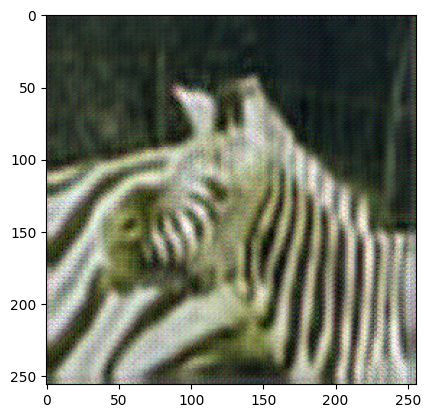

In [16]:
import matplotlib.pyplot as plt
plt.imshow(Image.open('/kaggle/working/saved_image/zebras/1200.png'))